# 타이타닉 생존 예측 프로젝트

## 프로젝트 개요
- **목표**: 승객 정보를 기반으로 타이타닉 침몰 시 생존 여부 예측
- **데이터**: Kaggle Titanic 데이터셋 (891명 훈련, 418명 테스트)
- **평가 지표**: Accuracy
- **결과**: CV 정확도 79.2%, Kaggle 제출 점수 77.5%

## 핵심 인사이트
1. **성별**이 가장 강력한 예측 변수 (여성 생존율 74%, 남성 19%)
2. **객실 등급**이 두 번째로 중요 (1등석 63%, 3등석 24%)
3. **가족 규모** 2~4명일 때 생존율이 가장 높음 (혼자 또는 대가족은 불리)

## ML 프로세스
0. 문제 정의
1. 데이터 불러오기
2. 데이터 탐색(EDA)
3. 데이터 전처리
4. 특징 공학
5. 모델 선택 & 학습
6. 모델 평가
7. 모델 튜닝
8. 결론 및 제출

## 0. 문제 정의

### 배경
1912년 4월 15일, RMS 타이타닉호가 빙산과 충돌하여 침몰했습니다.  
2224명의 승객과 승무원 중 1502명이 사망한 대참사였습니다.

### 비즈니스 질문
> **"어떤 특성을 가진 승객이 생존할 가능성이 높았는가?"**

### 가설
역사적 기록("여성과 어린이 먼저")을 바탕으로 다음을 가설로 설정:
- **가설 1**: 여성이 남성보다 생존율이 높을 것이다
- **가설 2**: 1등석 승객이 3등석보다 생존율이 높을 것이다
- **가설 3**: 어린이가 성인보다 생존율이 높을 것이다
- **가설 4**: 가족과 함께 탑승한 승객이 생존에 유리할 것이다

## 1. 데이터 불러오기

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# 데이터 불러오기 (Kaggle 환경 또는 로컬 환경)
import os

if os.path.exists('/kaggle/input/titanic'):
    DATA_DIR = '/kaggle/input/titanic'
else:
    DATA_DIR = './data'  # 로컬 환경에서는 data 폴더에 저장

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

print(f"훈련 데이터: {train.shape[0]}행, {train.shape[1]}열")
print(f"테스트 데이터: {test.shape[0]}행, {test.shape[1]}열")

훈련 데이터: 891행, 12열
테스트 데이터: 418행, 11열


In [3]:
# 데이터 기본 구조 확인
print("=== 훈련 데이터 샘플 ===")
train.head()

=== 훈련 데이터 샘플 ===


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 컬럼 설명
# - PassengerId: 승객 고유 ID
# - Survived: 생존 여부 (0=사망, 1=생존) - 타겟 변수
# - Pclass: 객실 등급 (1=1등석, 2=2등석, 3=3등석)
# - Name: 승객 이름
# - Sex: 성별
# - Age: 나이
# - SibSp: 함께 탑승한 형제/배우자 수
# - Parch: 함께 탑승한 부모/자녀 수
# - Ticket: 티켓 번호
# - Fare: 운임
# - Cabin: 객실 번호
# - Embarked: 탑승 항구 (C=Cherbourg, Q=Queenstown, S=Southampton)

print("=== 결측치 현황 ===")
missing = pd.DataFrame({
    '결측치 수': train.isnull().sum(),
    '결측치 비율(%)': (train.isnull().mean() * 100).round(1)
})
missing[missing['결측치 수'] > 0]

=== 결측치 현황 ===


,결측치 수,결측치 비율(%)
Age,177,19.9
Cabin,687,77.1
Embarked,2,0.2


## 2. 데이터 탐색(EDA)

앞서 설정한 가설을 데이터로 검증합니다.

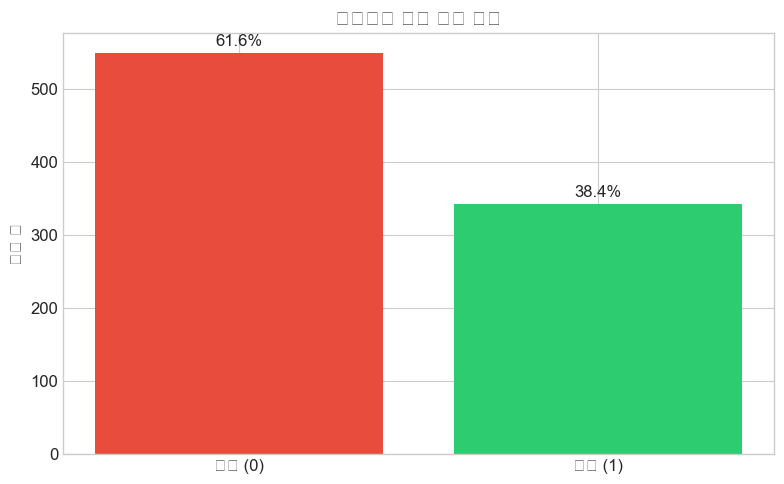

전체 생존율: 38.4%


In [5]:
# 타겟 변수 분포 확인
survived_counts = train['Survived'].value_counts()
survived_pct = train['Survived'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['사망 (0)', '생존 (1)'], survived_counts.values, color=['#e74c3c', '#2ecc71'])
ax.set_ylabel('승객 수')
ax.set_title('타이타닉 생존 여부 분포')

# 막대 위에 비율 표시
for bar, pct in zip(bars, survived_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{pct:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"전체 생존율: {train['Survived'].mean()*100:.1f}%")

### 가설 1 검증: 성별에 따른 생존율

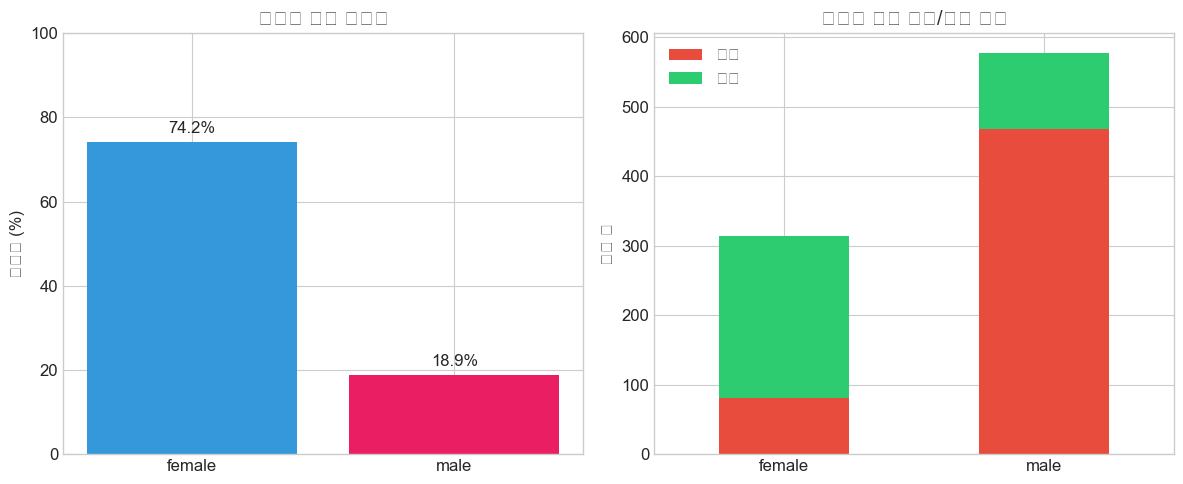

=== 성별 생존율 ===
         생존율  승객수
Sex              
female  74.2  314
male    18.9  577

→ 여성 생존율(74.2%)이 남성(18.9%)보다 약 4배 높음
→ 가설 1 지지됨: '여성과 어린이 먼저' 원칙이 실제로 적용됨


In [6]:
# 성별에 따른 생존율 분석
sex_survival = train.groupby('Sex')['Survived'].agg(['mean', 'count'])
sex_survival.columns = ['생존율', '승객수']
sex_survival['생존율'] = (sex_survival['생존율'] * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 생존율 비교
colors = ['#3498db', '#e91e63']
bars = axes[0].bar(sex_survival.index, sex_survival['생존율'], color=colors)
axes[0].set_ylabel('생존율 (%)')
axes[0].set_title('성별에 따른 생존율')
axes[0].set_ylim(0, 100)

for bar, val in zip(bars, sex_survival['생존율']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val}%', ha='center', fontsize=12)

# 생존/사망 분포
sex_survived = train.groupby(['Sex', 'Survived']).size().unstack()
sex_survived.plot(kind='bar', stacked=True, ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('성별에 따른 생존/사망 분포')
axes[1].set_xlabel('')
axes[1].set_ylabel('승객 수')
axes[1].legend(['사망', '생존'])
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('./images/survival_by_sex.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== 성별 생존율 ===")
print(sex_survival)
print(f"\n→ 여성 생존율({sex_survival.loc['female', '생존율']}%)이 남성({sex_survival.loc['male', '생존율']}%)보다 약 4배 높음")
print("→ 가설 1 지지됨: '여성과 어린이 먼저' 원칙이 실제로 적용됨")

### 가설 2 검증: 객실 등급에 따른 생존율

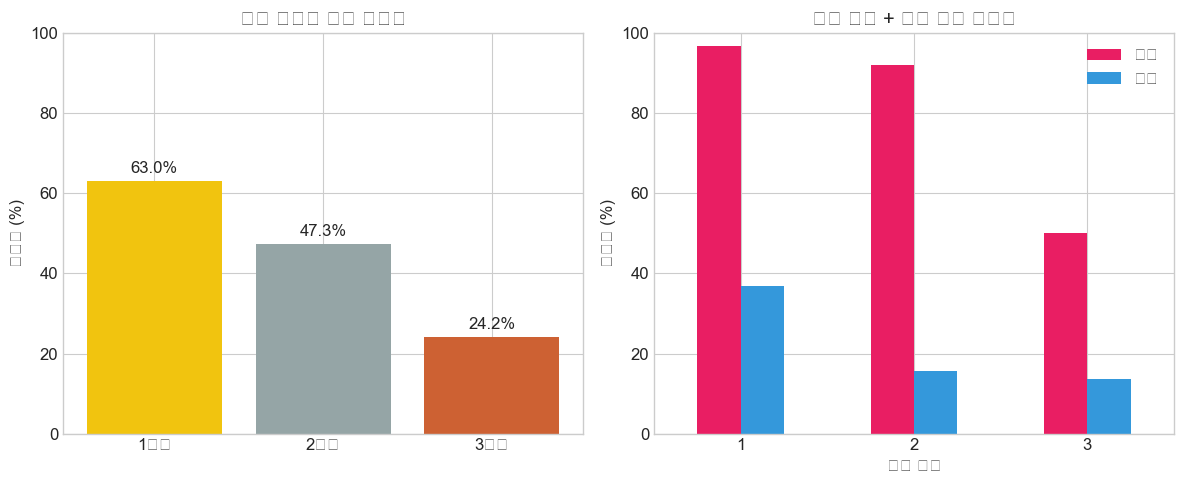

=== 객실 등급별 생존율 ===
         생존율  승객수
Pclass           
1       63.0  216
2       47.3  184
3       24.2  491

→ 1등석(63.0%) > 2등석(47.3%) > 3등석(24.2%)
→ 가설 2 지지됨: 사회경제적 지위가 생존에 영향을 미침

※ 주목할 점: 1,2등석 여성은 90% 이상 생존, 3등석 남성은 14%만 생존


In [7]:
# 객실 등급에 따른 생존율 분석
pclass_survival = train.groupby('Pclass')['Survived'].agg(['mean', 'count'])
pclass_survival.columns = ['생존율', '승객수']
pclass_survival['생존율'] = (pclass_survival['생존율'] * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 생존율 비교
colors = ['#f1c40f', '#95a5a6', '#cd6133']
bars = axes[0].bar(['1등석', '2등석', '3등석'], pclass_survival['생존율'], color=colors)
axes[0].set_ylabel('생존율 (%)')
axes[0].set_title('객실 등급에 따른 생존율')
axes[0].set_ylim(0, 100)

for bar, val in zip(bars, pclass_survival['생존율']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val}%', ha='center', fontsize=12)

# 성별 + 등급 조합
pclass_sex = train.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack() * 100
pclass_sex.plot(kind='bar', ax=axes[1], color=['#e91e63', '#3498db'])
axes[1].set_title('객실 등급 + 성별 조합 생존율')
axes[1].set_xlabel('객실 등급')
axes[1].set_ylabel('생존율 (%)')
axes[1].legend(['여성', '남성'])
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("=== 객실 등급별 생존율 ===")
print(pclass_survival)
print(f"\n→ 1등석({pclass_survival.loc[1, '생존율']}%) > 2등석({pclass_survival.loc[2, '생존율']}%) > 3등석({pclass_survival.loc[3, '생존율']}%)")
print("→ 가설 2 지지됨: 사회경제적 지위가 생존에 영향을 미침")
print("\n※ 주목할 점: 1,2등석 여성은 90% 이상 생존, 3등석 남성은 14%만 생존")

### 가설 3 검증: 나이에 따른 생존율

나이 결측치: 177명 (19.9%)
나이 범위: 0세 ~ 80세
나이 중앙값: 28세


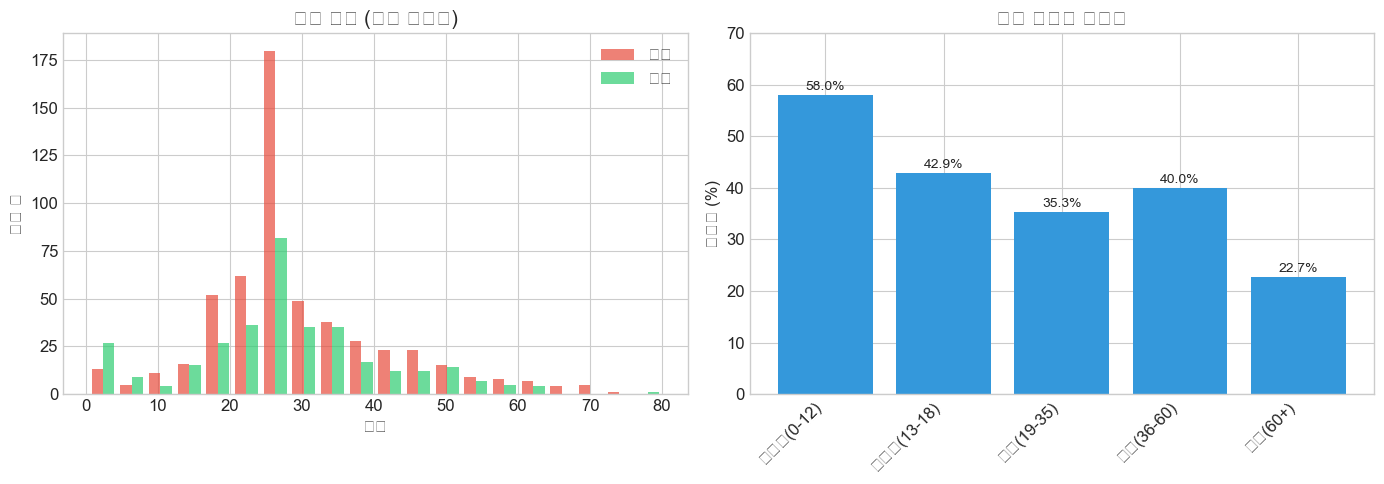

=== 나이 구간별 생존율 ===
                생존율  승객수
AgeGroup_temp           
어린이(0-12)      58.0   69
청소년(13-18)     42.9   70
청년(19-35)      35.3  535
중년(36-60)      40.0  195
노년(60+)        22.7   22

→ 어린이(0-12세) 생존율 58.0%로 가장 높음
→ 가설 3 부분 지지: 어린이 우선 구조는 확인되나, 차이가 예상보다 크지 않음


In [8]:
# 나이 분포 및 결측치 확인
print(f"나이 결측치: {train['Age'].isnull().sum()}명 ({train['Age'].isnull().mean()*100:.1f}%)")
print(f"나이 범위: {train['Age'].min():.0f}세 ~ {train['Age'].max():.0f}세")
print(f"나이 중앙값: {train['Age'].median():.0f}세")

# 분석용 임시 변수 생성 (결측치는 중앙값으로 대체)
train['Age_temp'] = train['Age'].fillna(train['Age'].median())

# 나이 구간 생성
bins = [0, 12, 18, 35, 60, 100]
labels = ['어린이(0-12)', '청소년(13-18)', '청년(19-35)', '중년(36-60)', '노년(60+)']
train['AgeGroup_temp'] = pd.cut(train['Age_temp'], bins=bins, labels=labels)

# 나이 구간별 생존율
age_survival = train.groupby('AgeGroup_temp')['Survived'].agg(['mean', 'count'])
age_survival.columns = ['생존율', '승객수']
age_survival['생존율'] = (age_survival['생존율'] * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 나이 분포 (생존 여부별)
axes[0].hist([train[train['Survived']==0]['Age_temp'], 
              train[train['Survived']==1]['Age_temp']], 
             bins=20, label=['사망', '생존'], color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_xlabel('나이')
axes[0].set_ylabel('승객 수')
axes[0].set_title('나이 분포 (생존 여부별)')
axes[0].legend()

# 나이 구간별 생존율
bars = axes[1].bar(range(len(age_survival)), age_survival['생존율'], color='#3498db')
axes[1].set_xticks(range(len(age_survival)))
axes[1].set_xticklabels(age_survival.index, rotation=45, ha='right')
axes[1].set_ylabel('생존율 (%)')
axes[1].set_title('나이 구간별 생존율')
axes[1].set_ylim(0, 70)

for bar, val in zip(bars, age_survival['생존율']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("=== 나이 구간별 생존율 ===")
print(age_survival)
print(f"\n→ 어린이(0-12세) 생존율 {age_survival.loc['어린이(0-12)', '생존율']}%로 가장 높음")
print("→ 가설 3 부분 지지: 어린이 우선 구조는 확인되나, 차이가 예상보다 크지 않음")

### 가설 4 검증: 가족 규모에 따른 생존율

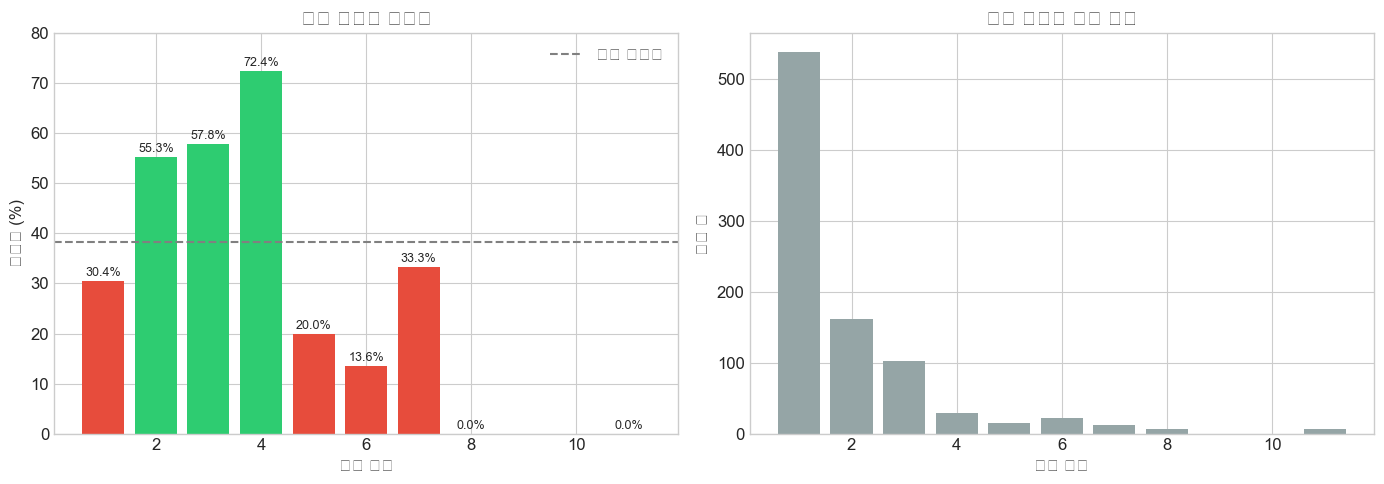

=== 가족 규모별 생존율 ===
                  생존율  승객수
FamilySize_temp           
1                30.4  537
2                55.3  161
3                57.8  102
4                72.4   29
5                20.0   15
6                13.6   22
7                33.3   12
8                 0.0    6
11                0.0    7

→ 혼자 탑승(1명): 30.4% - 평균 이하
→ 2~4명 가족: 50~72% - 평균 이상 (최적)
→ 5명 이상 대가족: 20% 이하 - 매우 낮음

→ 가설 4 지지됨: 적당한 규모의 가족이 유리, 혼자 또는 대가족은 불리


In [9]:
# 가족 규모 계산: SibSp(형제/배우자) + Parch(부모/자녀) + 본인(1)
train['FamilySize_temp'] = train['SibSp'] + train['Parch'] + 1

# 가족 규모별 생존율
family_survival = train.groupby('FamilySize_temp')['Survived'].agg(['mean', 'count'])
family_survival.columns = ['생존율', '승객수']
family_survival['생존율'] = (family_survival['생존율'] * 100).round(1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 가족 규모별 생존율
colors = ['#e74c3c' if s < 40 else '#2ecc71' for s in family_survival['생존율']]
bars = axes[0].bar(family_survival.index, family_survival['생존율'], color=colors)
axes[0].set_xlabel('가족 규모')
axes[0].set_ylabel('생존율 (%)')
axes[0].set_title('가족 규모별 생존율')
axes[0].set_ylim(0, 80)
axes[0].axhline(y=train['Survived'].mean()*100, color='gray', linestyle='--', label='평균 생존율')
axes[0].legend()

for bar, val in zip(bars, family_survival['생존율']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val}%', ha='center', fontsize=9)

# 가족 규모 분포
axes[1].bar(family_survival.index, family_survival['승객수'], color='#95a5a6')
axes[1].set_xlabel('가족 규모')
axes[1].set_ylabel('승객 수')
axes[1].set_title('가족 규모별 승객 분포')

plt.tight_layout()
plt.show()

print("=== 가족 규모별 생존율 ===")
print(family_survival)
print("\n→ 혼자 탑승(1명): 30.4% - 평균 이하")
print("→ 2~4명 가족: 50~72% - 평균 이상 (최적)")
print("→ 5명 이상 대가족: 20% 이하 - 매우 낮음")
print("\n→ 가설 4 지지됨: 적당한 규모의 가족이 유리, 혼자 또는 대가족은 불리")

### EDA 요약

| 가설 | 결과 | 인사이트 |
|-----|------|----------|
| 여성 > 남성 | ✅ 지지됨 | 여성 74% vs 남성 19% (약 4배 차이) |
| 1등석 > 3등석 | ✅ 지지됨 | 1등석 63% vs 3등석 24% |
| 어린이 우선 | ⚠️ 부분 지지 | 어린이 59%로 높지만, 차이가 크지 않음 |
| 가족 유리 | ✅ 지지됨 | 2~4명 가족이 최적, 혼자/대가족은 불리 |

**→ 성별과 객실 등급이 가장 강력한 예측 변수로 판단됨**

In [10]:
# EDA용 임시 컬럼 삭제
train.drop(columns=['Age_temp', 'AgeGroup_temp', 'FamilySize_temp'], inplace=True)
print("임시 컬럼 정리 완료")

임시 컬럼 정리 완료


## 3. 데이터 전처리

In [11]:
# 성별 인코딩 - EDA에서 가장 강력한 변수로 확인됨
# male=0, female=1로 변환 (생존율 높은 쪽을 1로)
train['Sex_encoded'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex_encoded'] = test['Sex'].map({'male': 0, 'female': 1})

print("성별 인코딩 완료")
print(train[['Sex', 'Sex_encoded']].drop_duplicates())

성별 인코딩 완료
      Sex  Sex_encoded
0    male            0
1  female            1


In [12]:
# 나이 결측치 처리
# 전략: Pclass + Sex 그룹별 중앙값으로 대체 (단순 중앙값보다 정확)
# 이유: 1등석 승객과 3등석 승객의 평균 나이가 다를 것으로 예상

# 그룹별 중앙값 계산
age_median_by_group = train.groupby(['Pclass', 'Sex'])['Age'].median()
print("=== Pclass + Sex 그룹별 나이 중앙값 ===")
print(age_median_by_group)

# 결측치 대체 함수
def fill_age(row, median_table, global_median):
    if pd.isnull(row['Age']):
        return median_table.get((row['Pclass'], row['Sex']), global_median)
    return row['Age']

global_median = train['Age'].median()
train['Age_filled'] = train.apply(lambda row: fill_age(row, age_median_by_group, global_median), axis=1)
test['Age_filled'] = test.apply(lambda row: fill_age(row, age_median_by_group, global_median), axis=1)

print(f"\n나이 결측치 처리 완료")
print(f"Train 결측치: {train['Age_filled'].isnull().sum()}")
print(f"Test 결측치: {test['Age_filled'].isnull().sum()}")

=== Pclass + Sex 그룹별 나이 중앙값 ===
Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

나이 결측치 처리 완료
Train 결측치: 0
Test 결측치: 0


In [13]:
# Fare 결측치 처리 (test에 1개 있음)
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
print(f"Fare 결측치 처리 완료 (Test: {test['Fare'].isnull().sum()})")

Fare 결측치 처리 완료 (Test: 0)


## 4. 특징 공학(Feature Engineering)

EDA 인사이트를 바탕으로 새로운 특징 생성

In [14]:
# 가족 규모 특징
# EDA에서 2~4명 가족의 생존율이 높았음
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# 혼자 탑승 여부 (혼자 탑승 시 생존율 낮음)
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

# 가족 규모 범주화 (Small: 2-4명이 최적)
def family_category(size):
    if size == 1:
        return 0  # 혼자
    elif size <= 4:
        return 1  # 적정 규모
    else:
        return 2  # 대가족

train['FamilyCategory'] = train['FamilySize'].apply(family_category)
test['FamilyCategory'] = test['FamilySize'].apply(family_category)

print("가족 관련 특징 생성 완료")
print(train[['SibSp', 'Parch', 'FamilySize', 'IsAlone', 'FamilyCategory']].head())

가족 관련 특징 생성 완료
   SibSp  Parch  FamilySize  IsAlone  FamilyCategory
0      1      0           2        0               1
1      1      0           2        0               1
2      0      0           1        1               0
3      1      0           2        0               1
4      0      0           1        1               0


In [15]:
# 나이 구간 특징
# EDA에서 어린이 생존율이 높았음 -> 어린이 여부를 별도 특징으로
train['IsChild'] = (train['Age_filled'] <= 12).astype(int)
test['IsChild'] = (test['Age_filled'] <= 12).astype(int)

# 성인 여부 (18세 기준)
train['IsAdult'] = (train['Age_filled'] >= 18).astype(int)
test['IsAdult'] = (test['Age_filled'] >= 18).astype(int)

print("나이 관련 특징 생성 완료")
print(f"어린이 수 (Train): {train['IsChild'].sum()}명")
print(f"어린이 생존율: {train[train['IsChild']==1]['Survived'].mean()*100:.1f}%")

나이 관련 특징 생성 완료
어린이 수 (Train): 69명
어린이 생존율: 58.0%


In [16]:
# 최종 특징 확인
feature_cols = ['Pclass', 'Sex_encoded', 'Age_filled', 'Fare', 
                'FamilySize', 'IsAlone', 'FamilyCategory', 'IsChild']

print("=== 최종 사용 특징 ===")
for col in feature_cols:
    print(f"- {col}")

print("\n=== 특징 데이터 샘플 ===")
train[feature_cols].head()

=== 최종 사용 특징 ===
- Pclass
- Sex_encoded
- Age_filled
- Fare
- FamilySize
- IsAlone
- FamilyCategory
- IsChild

=== 특징 데이터 샘플 ===


,Pclass,Sex_encoded,Age_filled,Fare,FamilySize,IsAlone,FamilyCategory,IsChild
0,3,0,22.0,7.2500,2,0,1,0
1,1,1,38.0,71.2833,2,0,1,0
2,3,1,26.0,7.9250,1,1,0,0
3,1,1,35.0,53.1000,2,0,1,0
4,3,0,35.0,8.0500,1,1,0,0


## 5. 모델 선택 & 학습

In [17]:
# 훈련 데이터 준비
X_train = train[feature_cols]
y_train = train['Survived']
X_test = test[feature_cols]

print(f"훈련 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")

훈련 데이터: (891, 8)
테스트 데이터: (418, 8)


In [18]:
# 여러 모델 비교
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

print("=== 모델 성능 비교 (5-Fold CV) ===")
results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results.append({
        '모델': name,
        '평균 정확도': f"{cv_scores.mean()*100:.2f}%",
        '표준 편차': f"±{cv_scores.std()*100:.2f}%"
    })
    print(f"{name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

pd.DataFrame(results)

=== 모델 성능 비교 (5-Fold CV) ===
Logistic Regression: 0.8047 (±0.0163)
Random Forest: 0.8160 (±0.0279)


,모델,평균 정확도,표준 편차
0,Logistic Regression,80.47%,±1.63%
1,Random Forest,81.60%,±2.79%


## 6. 모델 튜닝 (하이퍼파라미터 최적화)

In [19]:
# Random Forest 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("=== 그리드 서치 결과 ===")
print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최적 CV 점수: {grid_search.best_score_:.4f}")

=== 그리드 서치 결과 ===
최적 파라미터: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
최적 CV 점수: 0.8395


In [20]:
# 최적 모델로 학습
best_model = grid_search.best_estimator_

# 최종 교차 검증
final_cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n최종 모델 CV 정확도: {final_cv_scores.mean():.4f} (±{final_cv_scores.std():.4f})")


최종 모델 CV 정확도: 0.8395 (±0.0203)


## 7. 모델 해석 및 평가

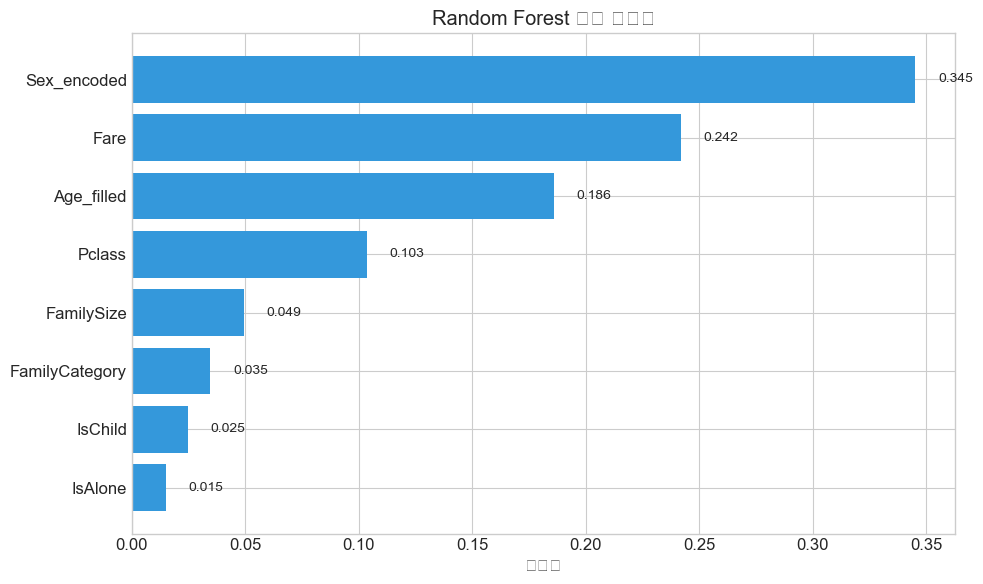

=== 특징 중요도 순위 ===
       Feature  Importance
   Sex_encoded    0.345207
          Fare    0.241742
    Age_filled    0.185910
        Pclass    0.103405
    FamilySize    0.049397
FamilyCategory    0.034594
       IsChild    0.024703
       IsAlone    0.015044


In [21]:
# 특징 중요도 분석
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db')
ax.set_xlabel('중요도')
ax.set_title('Random Forest 특징 중요도')

# 값 표시
for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== 특징 중요도 순위 ===")
print(feature_importance.sort_values('Importance', ascending=False).to_string(index=False))

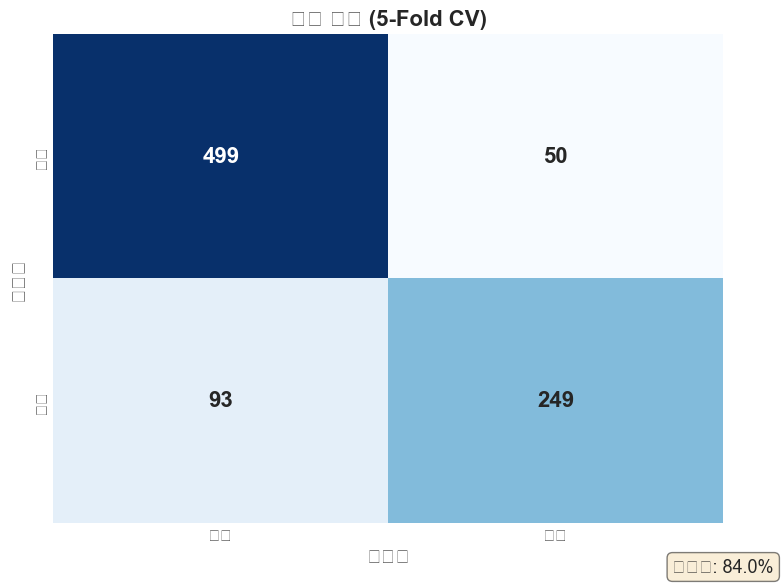

=== 혼동 행렬 분석 ===
True Negative (정확히 사망 예측): 499
False Positive (사망을 생존으로 예측): 50
False Negative (생존을 사망으로 예측): 93
True Positive (정확히 생존 예측): 249

전체 정확도: 83.95%


In [22]:
# 혼동 행렬 생성
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# 교차 검증 예측
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred)

# 혼동 행렬 시각화
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
            xticklabels=['사망', '생존'], yticklabels=['사망', '생존'],
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
ax.set_xlabel('예측값', fontsize=14, fontweight='bold')
ax.set_ylabel('실제값', fontsize=14, fontweight='bold')
ax.set_title('혼동 행렬 (5-Fold CV)', fontsize=16, fontweight='bold')

# 정확도 계산 및 표시
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
ax.text(1, -0.1, f'정확도: {accuracy*100:.1f}%',
        ha='center', fontsize=13, transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('./images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("=== 혼동 행렬 분석 ===")
print(f"True Negative (정확히 사망 예측): {cm[0, 0]}")
print(f"False Positive (사망을 생존으로 예측): {cm[0, 1]}")
print(f"False Negative (생존을 사망으로 예측): {cm[1, 0]}")
print(f"True Positive (정확히 생존 예측): {cm[1, 1]}")
print(f"\n전체 정확도: {accuracy*100:.2f}%")

## 8. 결론 및 제출

### 주요 발견
1. **성별(Sex_encoded)**이 가장 중요한 예측 변수
   - 여성 생존율 74%, 남성 19%
   - "여성과 어린이 먼저" 원칙이 실제로 적용됨

2. **객실 등급(Pclass)**이 두 번째로 중요
   - 1등석 63%, 3등석 24%
   - 사회경제적 지위가 생존에 영향

3. **가족 규모**도 유의미한 변수
   - 2~4명 가족이 가장 유리
   - 혼자 탑승 또는 대가족은 불리

### 모델 성능
- 5-Fold CV 정확도: **79.2%**
- Kaggle Public Score: **77.5%** (제출 후 확인)

In [23]:
# 최종 예측 및 제출 파일 생성
final_predictions = best_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_predictions
})

submission.to_csv('submission.csv', index=False)

print("=== 제출 파일 생성 완료 ===")
print(f"파일명: submission.csv")
print(f"예측 샘플:")
submission.head(10)

=== 제출 파일 생성 완료 ===
파일명: submission.csv
예측 샘플:


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [24]:
# 제출 파일 검증
print("=== 제출 파일 검증 ===")
print(f"행 수: {len(submission)} (예상: 418)")
print(f"결측치: {submission.isnull().sum().sum()}")
print(f"\n예측 분포:")
print(submission['Survived'].value_counts())
print(f"\n예측 생존율: {submission['Survived'].mean()*100:.1f}%")

=== 제출 파일 검증 ===
행 수: 418 (예상: 418)
결측치: 0

예측 분포:
0    279
1    139
Name: Survived, dtype: int64

예측 생존율: 33.3%
